# Approximate Nearest Neighbor Search

In this notebook, we'll try 'rolling our own' search functions, working with real data from the Intaka dataset.

In [ ]:
# Install hoplite and TF 2.20
!pip install git+https://github.com/google-research/perch-hoplite.git
!pip install tensorflow~=2.20.0


  Cloning https://github.com/google-research/perch-hoplite.git to /tmp/pip-req-build-tec2o3r6
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch-hoplite.git /tmp/pip-req-build-tec2o3r6
  Resolved https://github.com/google-research/perch-hoplite.git to commit b075df9dfe2eedbaebfd3e97a52b4cffe3569fe2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.0 MB/s eta 0:00:00
   ━━━

In [ ]:
#@title Copy the database locally. { vertical-output: true }

from etils import epath
import os
intaka_path = epath.Path('gs://chirp-public-bucket/soundscapes/intaka')

# Copy the hoplite database to the Colab local storage.
# The usearch.index file is 3.6Gb, so takes a couple minutes to download.
# Files are placed in `/content` directory.
for fp in intaka_path.glob('hoplite*'):
  print(fp)
  with fp.open('rb') as f:
    with open(fp.name, 'wb') as g:
      g.write(f.read())
with (intaka_path / 'usearch.index').open('rb') as f:
  print(intaka_path / 'usearch.index')
  with open('usearch.index', 'wb') as g:
    %time g.write(f.read())



gs://chirp-public-bucket/soundscapes/intaka/hoplite.sqlite
gs://chirp-public-bucket/soundscapes/intaka/hoplite.sqlite-shm
gs://chirp-public-bucket/soundscapes/intaka/hoplite.sqlite-wal
gs://chirp-public-bucket/soundscapes/intaka/usearch.index
CPU times: user 9.18 s, sys: 13.6 s, total: 22.8 s
Wall time: 2min 54s


In [ ]:
#@title Connect to the database. { vertical-output: true }
import os

from matplotlib import pyplot as plt
import numpy as np

from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import classifier_data
from perch_hoplite.agile import embedding_display
from perch_hoplite.agile import source_info
from perch_hoplite.db  import brutalism
from perch_hoplite.db import score_functions
from perch_hoplite.db  import search_results
from perch_hoplite.db import sqlite_usearch_impl
from perch_hoplite.zoo import model_configs

db_path = '/content'  #@param {type:'string'}
#@markdown Identifier (eg, name) to attach to labels produced during validation.
annotator_id = 'linnaeus'  #@param {type:'string'}

db = sqlite_usearch_impl.SQLiteUsearchDB.create(db_path)
# Update the DB with some override values...
# Need to use the perch_v2_cpu model, and point the db to the google cloud
# bucket containing the data.
model_cfg = db.get_metadata('model_config')
model_cfg.model_config.tfhub_path = 'google/bird-vocalization-classifier/tensorFlow2/perch_v2_cpu'
model_cfg.model_config.tfhub_version = 1
db.insert_metadata('model_config', model_cfg)

sources_cfg = db.get_metadata('audio_sources')
sources_cfg.audio_globs[0]['base_path'] = 'gs://chirp-public-bucket/soundscapes/intaka'
db.insert_metadata('audio_sources', sources_cfg)
db.commit()

db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
if hasattr(embedding_model, 'window_size_s'):
  window_size_s = embedding_model.window_size_s
else:
  window_size_s = 5.0
audio_filepath_loader = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)

In [ ]:
# YOUR CODE GOES HERE
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Let's warm up by making some simple interactions...
# Consult the database API in the hoplite repository to finish these.
# https://github.com/google-research/perch-hoplite/blob/main/perch_hoplite/db/interface.py

# 1) Print the number of embeddings in the database.
all_ids = db.get_embedding_ids()
count = db.count_embeddings()

print(f"Number of embeddings is {len(all_ids)}")
# 2) Make a numpy array with a random set of 10,000 embeddings from the database.
subset_ixs = np.random.choice(all_ids, size=10_000)
# get_embeddingds
_, subset = db.get_embeddings(subset_ixs)


Number of embeddings is 1125507


In [ ]:
# 3) Make a tSNE scatter plot of these 10k embeddings.
subset_TSNE = TSNE(n_components=2).fit_transform(subset)

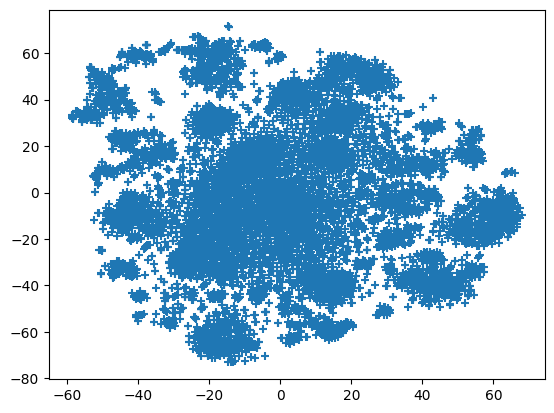

In [ ]:
fig = plt.figure()
plt.scatter(subset_TSNE[:,0], subset_TSNE[:,1], marker='+')
plt.show()

In [ ]:
# YOUR CODE GOES HERE
from perch_hoplite import audio_io
# Now let's try some brute-force search.

# 1) Get some audio from Xeno-Canto.
query_uri = 'xc878058' #@param
frame_rate = 100

query = embedding_model.embed(
    query.get_audio_window()).embeddings[0, 0]

In [ ]:
# 2) Use `embedding_model.embed` to get an embedding from the audio:
#    this is your query.
from time import time
from perch_hoplite.db import brutalism

start = time()
score_fn = np.dot
results, scores = brutalism.threaded_brute_search(db, query, 100, score_fn)
elapsed = time() - start
print(f"Elapsed time is {elapsed} seconds")

AttributeError: 'SQLiteUsearchDB' object has no attribute 'brutalism'

In [ ]:
# 3) Find the 100 nearest neighbors in the database to the query, according
#    to whatever metric you like, using code you write yourself.
# How fast does your searhc run (ignoring the time to make the query)?
# Can you make it run faster?
# (Hint: numpy operations are fast, python operations are slow...)

# (Challenge: If you can search the database faster than
#  hoplite.db.brutalism.threaded_brute_search, you will get a cookie.)

In [ ]:
# YOUR CODE GOES HERE

# Now let's try cluster-based search.

# 1) Cluster the audio in the database with K-Means.
# 2) Arrange the embedding data into clusters.
# 3) Write a function which uses these clusters and the cluster centroids
#    to search the data.
# 4) Check how long it takes to run. Is it faster than brute force search?
#    Can you make it faster?
# 5) What is the top-100 recall of your cluster-based search?
#    Use random embeddings from the database as queries.